<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classification-VIT/Brain_Tumour_Detection_Using_VIT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the Dataset

In [ ]:
# Load dataset
def load_dataset(data_dir, target_size=(224, 224)):
    images = []
    labels = []
    for label, folder in enumerate(['tumor', 'no_tumor']):
        folder_path = os.path.join(data_dir, folder)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size, color_mode='grayscale')
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)


Define the Vision Transformer Model (ViT)

In [ ]:
# Vision Transformer Model
def create_vit_model(input_shape, num_classes=2):
    from tensorflow.keras.layers import (
        Dense, LayerNormalization, MultiHeadAttention, Dropout, Layer, Input, Flatten, Embedding
    )
    from tensorflow.keras.models import Model

    class Patches(Layer):
        def __init__(self, patch_size):
            super(Patches, self).__init__()
            self.patch_size = patch_size

        def call(self, images):
            patches = tf.image.extract_patches(
                images=images,
                sizes=[1, self.patch_size, self.patch_size, 1],
                strides=[1, self.patch_size, self.patch_size, 1],
                rates=[1, 1, 1, 1],
                padding="VALID",
            )
            num_patches = (input_shape[0] // self.patch_size) * (input_shape[1] // self.patch_size)
            return tf.reshape(patches, [-1, num_patches, self.patch_size * self.patch_size])

    class TransformerBlock(Layer):
        def __init__(self, embed_dim):
            super(TransformerBlock, self).__init__()
            self.layer_norm1 = LayerNormalization()
            self.mha = MultiHeadAttention(num_heads=8, key_dim=embed_dim)
            self.dropout1 = Dropout(0.1)
            self.layer_norm2 = LayerNormalization()
            self.dense = Dense(embed_dim, activation="relu")
            self.dropout2 = Dropout(0.1)

        def call(self, inputs):
            x = self.layer_norm1(inputs)
            attn_output = self.mha(x, x, x)
            x = self.dropout1(attn_output) + inputs
            x = self.layer_norm2(x)
            dense_output = self.dense(x)
            x = self.dropout2(dense_output) + x
            return x

    inputs = Input(shape=input_shape)
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    patches_layer = Patches(patch_size)
    patches = patches_layer(inputs)

    embed_dim = 256
    projection = Dense(embed_dim)(patches)
    positions = Embedding(input_dim=num_patches, output_dim=embed_dim)(tf.range(start=0, limit=num_patches, delta=1))
    encoded_patches = projection + positions

    x = TransformerBlock(embed_dim=embed_dim)(encoded_patches)
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)


Load and Prepare the Dataset

In [ ]:
data_dir = "/content/drive/MyDrive/DSGP_BrainTumorDetection/DSGP_Preprocessed_Images"
input_shape = (224, 224, 1)


Split the data into Training and Testing Sets

In [ ]:
X, y = load_dataset(data_dir, target_size=(224, 224))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (4292, 224, 224, 1), Test shape: (1840, 224, 224, 1)


Create and Compile the ViT Model

Compile the Model

In [ ]:
# Create the model
model = create_vit_model(input_shape=input_shape, num_classes=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model created successfully.")


Model created successfully.


Train the Model

In [ ]:
# Train the Model with a batch size of 32 or adjust evaluation batch size
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 616s 5s/step - accuracy: 0.6304 - loss: 1.1028 - val_accuracy: 0.8152 - val_loss: 0.4253
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 623s 5s/step - accuracy: 0.8327 - loss: 0.3989 - val_accuracy: 0.8973 - val_loss: 0.2818
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 615s 5s/step - accuracy: 0.8996 - loss: 0.2669 - val_accuracy: 0.9185 - val_loss: 0.2246
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.9486 - loss: 0.1597 - val_accuracy: 0.9049 - val_loss: 0.2417
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 608s 5s/step - accuracy: 0.9509 - loss: 0.1404 - val_accuracy: 0.9543 - val_loss: 0.1607
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 630s 5s/step - accuracy: 0.9821 - loss: 0.0767 - val_accuracy: 0.9647 - val_loss: 0.1163
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 626s 5s/step - accuracy: 0.9910 - loss: 0.0428 - val_accuracy: 0.9620 - val_loss: 0.1315
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 607s 4s/step - accuracy: 0.9961 - loss: 0.0272 - val_accu

Evaluate the Model

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
y_pred = model.predict(X_test).argmax(axis=1)

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")



58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9731 - loss: 0.1080
58/58 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step
Test Accuracy: 97.28%
Test Precision: 96.79%
Test Recall: 97.65%


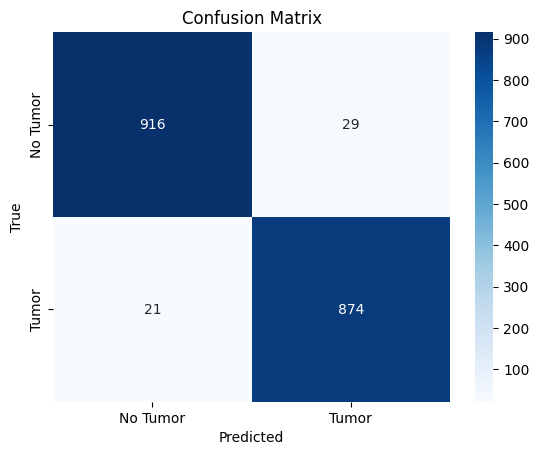

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
